# Basic queries on a numerical dataset

We are going to test the applicability of the already given ARX mechanisms on a numerical dataset. Our goal is to run basic queries, such as mean value, sum and max elements on the dataset's records. We are going to do that first by applying no DP at all, and then by using the API that is presented by ARX.

## The identity of the dataset:  NBA Players salaries


The dataset contains sensitive data regarding NBA players' salaries from the year 1990 until today. It also states other info about them, such as their age, their current team and their position.

## Process of running the queries

As we have earlier noted, the application of DP in ARX is rather complicated, let along the use that we are interested in: We want the output dataset to have numerical values in the earnings' column, in order to apply queries. 

For each column of the dataset, we have defined our own hierarchies. For every column except the `Salaries` one, this hierarchy is semantic, like the ones presented in our intro for age.

For the salaries column, with it being our goal to analyze, we opt to use the construction mentioned in our solution in the intro. We created 10 layers, in order to give the algorithm the ability to anonymize the dataset without the values being converted to `*`.


## Setup of the Mechanism

In order to run our queries, we use the ARX API, which requires us to specify some variables in order to run Differential Privacy. Those variables are defined in the above Java code.

```Java
    EDDifferentialPrivacy criterion = new EDDifferentialPrivacy(2d, 1d / Rows);

    ARXConfiguration config = ARXConfiguration.create();
    config.addPrivacyModel(criterion);
    config.setSuppressionLimit(1d);
    config.setHeuristicSearchStepLimit(100);
    ARXResult result = anonymizer.anonymize(data, config);
```

This way, our setup is ready, and now we must define a function in order to run this repetitively.

## Running the Queries

Following the same principles as with the IBM library, we are going to run the DP query multiple times before reporting its value. We are going to do so, because the amount of noise generated can be extreme, and because of the low bounds of the heuristic search that we have set. We chose to run each query `1000` times, and then report the mean value of those runs as the result produced by the mechanism.

## Query types

Because of the structure of the result of the ARX mechanism (a dataset containing numerical values), we can only run queries like __sum__ and __mean__. There is no point in running a min or max query: we already know that the result will not be accurate. Thus, we are going to try to run a __mean value__ numerical query in the anonymized dataset. The function we are using in order to run this typed of queries is the following:

```Java
	protected static double run_query(ARXResult data, int targetColumn) {
		// iterator that we are going to use to access the data
		final Iterator<String[]> itHandle = data.getOutput().iterator();
		
		// result of the query
		double result = 0d;
		// length of the dataset
		int totalRecords = 0;
		
		// get the first element of the column, thus the name of it, and ignore it
		String[] name = itHandle.next();
		if (name.length <= targetColumn) {
			System.out.println("Target column out of bounds\n");
			return 0d;
		}

		// iterate through all the values in the dataset
		while(itHandle.hasNext()) {
			String[] next = itHandle.next();
			// check that our target position is legal
			String string = next[targetColumn];
			if (!string.equals("*")) {
				result += Integer.parseInt(string);		
				totalRecords++;				
			}
		}
        // return the __mean__ of the dataset
        return result / totalRecords;
	}
	

```

## Privacy Settings

As mentioned in the SafePub paper(ref), in order to run the DP algorithm effectively, we must __set the delta parameter to be inversely proportional to the length of the dataset__. 

Also, in order for the algorithm to produce fine results, the __size of the dataset must be significant__.

## Running the query

First off, let's check the result of the non-DP query, in order to know what to expect.

In [1]:
import pandas as pd
import numpy as np

DATASET = "./nba_salaries.csv"
df = pd.read_csv(DATASET)

print(len(df))

mean_wo_dp = np.mean(df['Salary'])
print (mean_wo_dp)

12377
2868981.323341682


When running the query in the ARX API, using our own-defined functions, with the privacy variable epsilon having the value 1 we get the following result

In [16]:
2860215.692783765

2860215.692783765

We observe that the query results, are somewhat close: We are in the range of millions of dollars, and the ARX mechanism only fails to approach the result by 8 thousand.

## Observations from the algorithm

During our testings in the dataset using the ARX mechanism, we observe the following regarding its behavior in the DP queries:

 - The epsilon variable if raised above `2,5`, makes the algorithm extremely slow, to the point that it does not respond after minutes of execution. This makes sense, if we take into consideration that when epsilon increases, the accuracy gets better. Thus, the algorithm performs extreme searching techniques in order to find which records to suppress, resulting into slow execution
 - In order for the algorithm not to produce only `*` in our target column, we set each of the other columns as non sensitive in their definition.
 - As the epsilon values rise, the accuracy gets better, as it is supposed to be, according to the DP principles.
 - While the dataset has multiple columns, the algorithm usually fails to present all of them with anonymized values, and just reports `*` in each row. This could have been a result of the high `Heuristic Search Step Limit`, which was by default set to maximum. Despite us lowering its value, the phenomenon persists.

## Plots

Let's now take a look at the accuracy of the query when changing the value of epsilon. We have conducted tests by using the above mentioned functions, and by each time altering the value of the epsilon parameter.

In [2]:
# epsilon values we are going to run the query with
epsilon = [round(i/5 + 0.2, 4) for i in range (0,8)]
print(epsilon)

[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]


In [3]:
query_results = [2447509.4905001116, 2580120.4023217317, 2742689.1788798757, 2857291.001683826, 
                 2860215.692783765, 2870191.006886425, 2863787.4636055822, 2874546.3281011535]

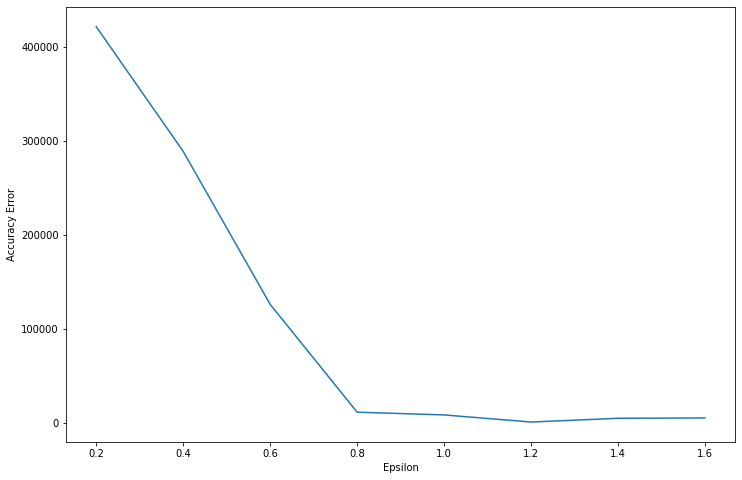

In [4]:
import matplotlib.pyplot as plt
errors = [abs(mean_wo_dp - acc) for acc in query_results]

# print (errors)

plt.figure(figsize = (12,8))
plt.plot(epsilon, errors, label='Accuracy error')

plt.xlabel('Epsilon')
plt.ylabel('Accuracy Error')
plt.savefig('arx_accuracy.png')
plt.show()

## Observations from the plot

As we can see, the plot does not behave as expected, but it is in the right direction. We are used to seeing a more logarithmic-like plot, but here we observe that when the epsilon rises above `0.8`, the results are similar. We can not compare the results with the LaPlace noise distribution, because of the way that the results are produced. 

We generate the answers given by asking the query in the output dataset. Without its records being suppressed, the result dataset would have been perfect, because of the transformation of the data. However, when suppressing many records (nearly 10% each time), the result could be severely altered, and thus the error plot, as we saw, is quite unpredictable. 

## Conclusions

While researching the ARX mechanism we came to the conclusion that it is for sure a whole different approach in Differential Privacy compared to the other libraries that we studied. With that being the case, it has some advantages and some disadvantages. Its main advantages are the following:

 - The result of the mechanism is a handy dataset that the user can handle in multiple ways and gain more information than just the result of a query.
 - The result can be iterated, thus giving the option to the user to run the query in a smaller subset of the rows, while it being differential private.
 
On the other hand, the main disadvantages are:
 
 
 - The result can be misleading, because of the big accuracy error produced
 - The algorithm requires a rather big dataset in order to run properly, while other libraries perform just fine with smaller datasets.
 - The algorithm is difficult to implement, as you have to create a self-made function for every query, and moreover tune many parameters if you want to run differential privacy.